# E Commerce Customer Churn

## Business Problem Understanding

**Context**

`An E-Commerce company would like to reduce their customer churn rate`. As such, they would like to identify customers who are going to churn. Knowing which customers have a risk to churn can greatly enhance decision-making processes on retention effort and can further help reduce churn to improve profitability and keep the company sustainable.

The company also keep track of the user's data, which includes their demographic and behaviours in the platform, as well as flagging those who churned.


Target:

0 : Does not Churn

1 : Has Churn

**Problem Statement:**

E-commerce is a business model that provide a platform for their customers to purchase goods which are majorly sold by various stores via online. The company mainly generate profit from service fees for making transactions via their platform, and so `it is vital for an ecommerce company to make sure their customers are still willing to use their service and does not churn` (leave the platform) so that they can increase their customer count and generate more profit.

Churns are to be expected, but when the churn is high, it could highly impact the bottom line of the company since they would not be able to generate enough profit to keep the company sustainable. The recent tech winter in Indonesia is one of the biggest example of this, where since 2022 until currently ongoing (mid of 2023), there are many layoff conducted by all major e-commerces, with some going bankrupt, due to not being profitable enough to sustain themselves. As such, `detecting churn` and `maintaining customer count` is one of the most important aspect for an e-commerce company to do for their sustainability.

On the other end, customer retention efforts is extremely costly if distributed indiscriminatively, especially when the company have many active customer in their platform. So, making sure that `only customers at risk of churning receive the retention` effort is also important.


**Goals:**

Based on the defined problems, the company decided that they should focus on `identifying customers who are at risk of churning` so that they can try approaching those customers to provide retention efforts in the form of personalized promos in hopes to make them stay, while also making sure that `only customers at risk of churning receive the retention` effort.

In addition, the company would also like to know `what makes a customer churn` from their platform in order to create better desicions in the future on reducing churn


**Analytic Approach:**

While ideally an Exploratory Data Analysis is to be conducted to find patterns that can help distinguish customers who churn, as requested, exclusively in this project we will be `focusing on building a classification model` which can help the company `predict customers who are at risk of churning` as well as `explaining which features are the most important` in determining whether a customer would churn.

**Metric Evaluation**

Type 1 error: False Positive  
Consequence: Loss from unnecessary retention effort

Type 2 error: False Negative  
Consequence: Failing to potentially prevent customer churn -> risk of losing company sustainability

While failing to prevent customers from churning yields a much larger impact than unnecessary increase in customer retention effort, the company do not wish to distribute retention effort fund inefficiently.

As such, we will focus only on the Positive class, and we want to `maximize true positives` while also `reducing false positives` as much as possible since both are equally costly in this context. Hence, the `F1 Score` is used to evaluate our model performance.


- Model: Classification Supervised Learning
- Features = all except target (there are not really that many features to risk overfitting)
- Target = Churn (1)
- Performance Metrics: F1 Score

## Library

Here, we just include all the libraries we would probably use

In [40]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score

# Imbalanced dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Ignore warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

import pickle

In [4]:
df = pd.read_csv('data_ecommerce_customer_churn.csv')
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
...,...,...,...,...,...,...,...,...,...,...,...
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0
3939,6.0,NaN,4,Mobile,3,Married,10,1,0.0,124.37,1


## Data Understanding

In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().values)])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Tenure,float64,194,4.92,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,..."
1,WarehouseToHome,float64,169,4.29,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,int64,0,0.00,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,object,0,0.00,6,"[Laptop & Accessory, Mobile, Fashion, Others, ..."
4,SatisfactionScore,int64,0,0.00,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,object,0,0.00,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,0,0.00,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,int64,0,0.00,2,"[0, 1]"
8,DaySinceLastOrder,float64,213,5.40,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,..."
9,CashbackAmount,float64,0,0.00,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.8..."


In [6]:
print('% of rows with Missing Value:' , df[df.isna().any(axis=1)].shape[0]/df.shape[0]*100)

% of rows with Missing Value: 14.615579802080692


**Features**
- Tenure: Tenure of a customer in the company..
- WarehouseToHome: Distance between the warehouse to the customer’s home.
- NumberOfDeviceRegistered: Total number of deceives is registered on a particular customer.
- PreferedOrderCat: Preferred order category of a customer in the last month.
- SatisfactionScore: Satisfactory score of a customer on service.
- MaritalStatus: Marital status of a customer.
- NumberOfAddress: Total number of added on a particular customer.
- Complaint: Any complaint has been raised in the last month.
- DaySinceLastOrder: Day since last order by customer.
- CashbackAmount: Average cashback in last month
- Churn: Churn flag [`Target`]

Every rows represent a Customer from the E-commerce Company

Based on its type, we can categorize the variables on the dataset as below:

Quantitative:
- Continuous: `Tenure`, `WarehouseToHome`, `CashbackAmount`, `DaySinceLastOrder`
- Discrete: `NumberOfDeviceRegistered`, `NumberOfAddress`

Qualitative:
- Nominal Categorical: `PreferedOrderCat`, `MaritalStatus`
- Ordinal : `SatisfactionScore`
- Binary (Dichotomous Variable):  `Complain`, `Churn` (Target)

Data Quality: 
- There are Missing Values at `Tenure`, `WarehouseToHome`, and `DaySinceLastOrder` approximately 5% of total data in their respective columns, making up to 14.6% of rows with missing value.
- There are no typos or anomaly for the categorical values.
- Considering the Non-Parametric nature of this modelling, we will only consider to deal with outliers if we intend to use Logistic Regression as our estimator.

### Data Cleaning

Missing Value

<Axes: >

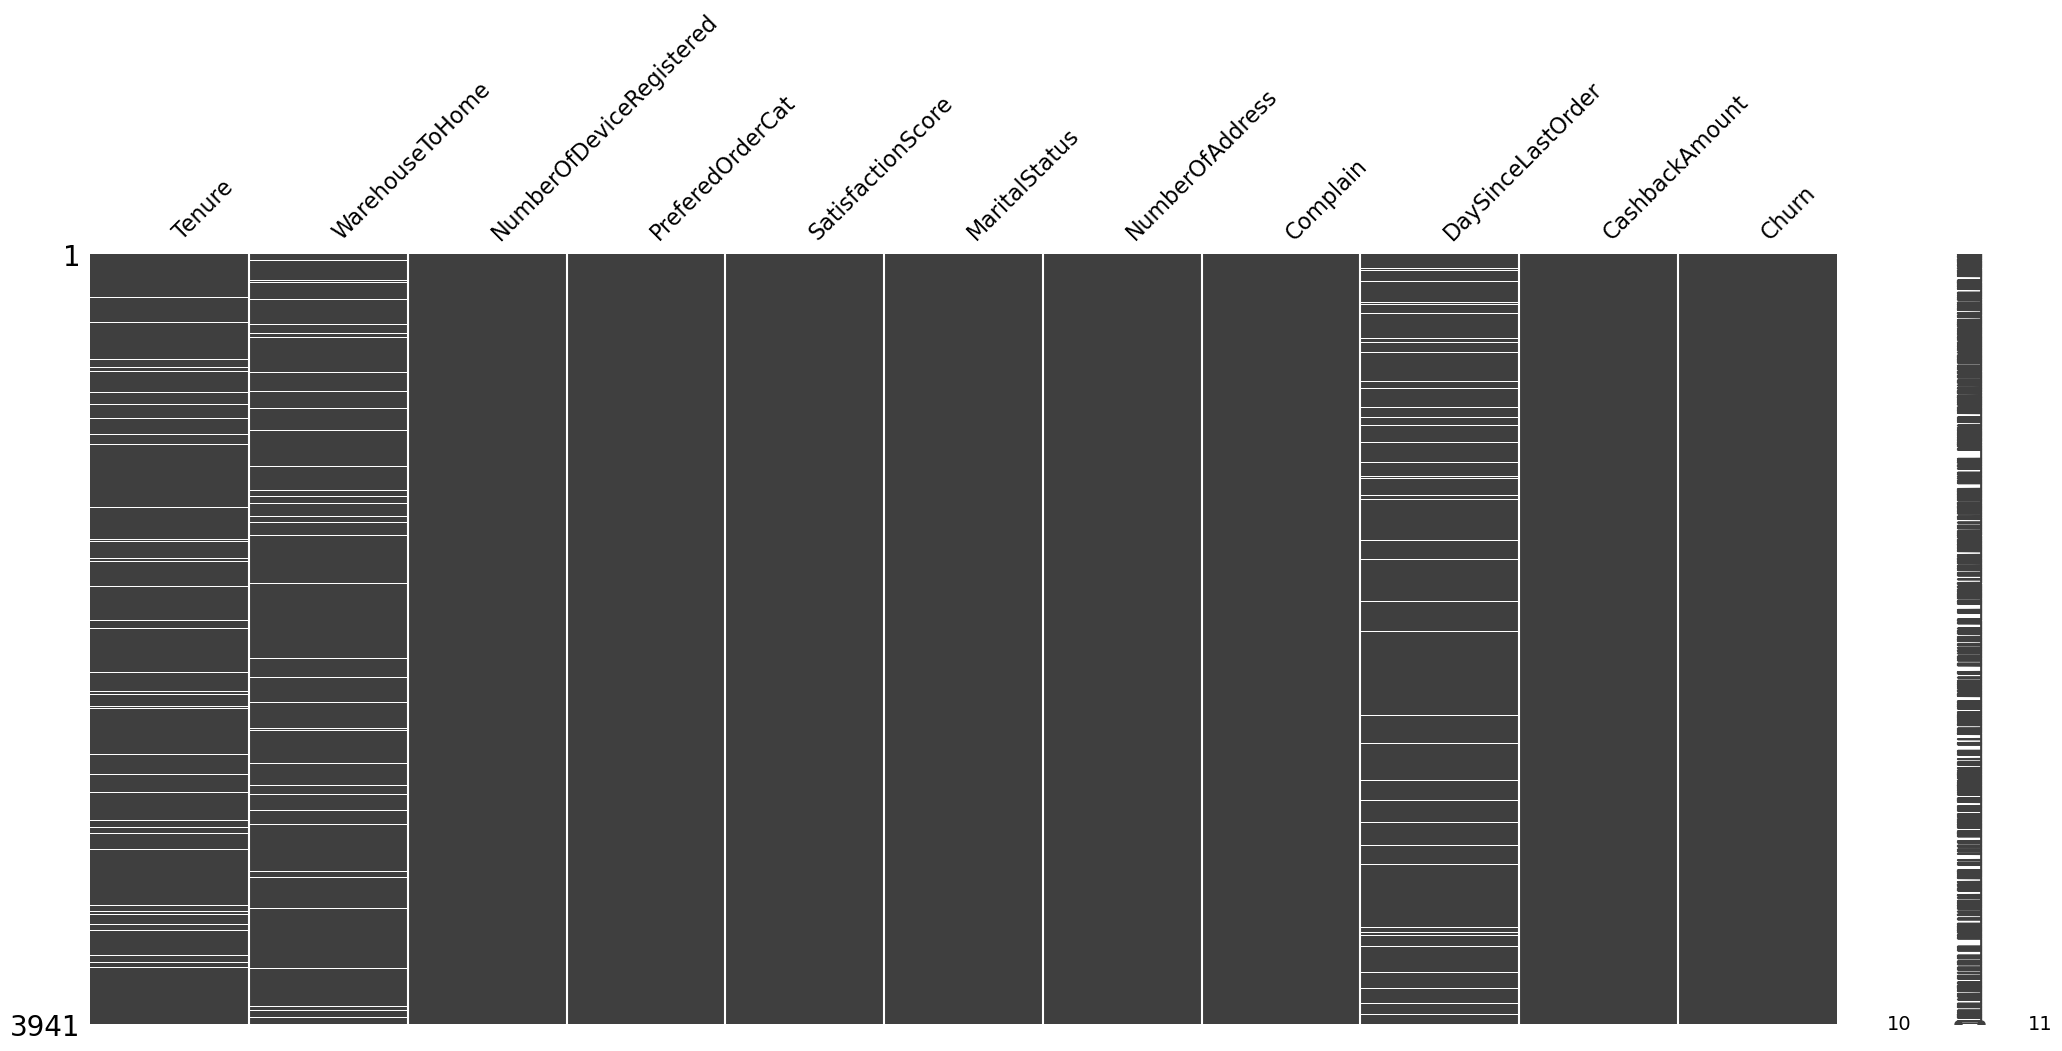

In [7]:
missingno.matrix(df)

There does not seem to be any apparent pattern regarding the location of Missing Values in the data

<Axes: >

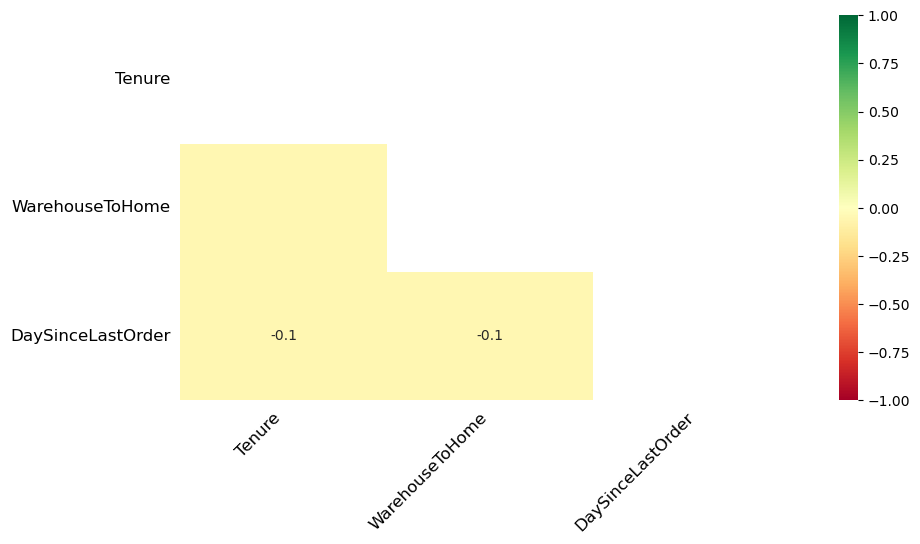

In [8]:
missingno.heatmap(df, cmap="RdYlGn", figsize=(10,5), fontsize=12)

The Heatmap shows nullity correlation ranged between -1 to 1.

- -1: Negative correlation, stating that if a value of one variable is missing, the value of the other variable is not missing.

- 0: No correlation between missing values in the variables.

- 1: Positive correlation, stating that if a value of one variable is missing, the value of the other variable is also missing.

From the Heatmap, we can infer:
- There is no apparent correlation between missing values in the variables (very close to 0)
- This seems to heavily imply that the missing data is MCAR or MAR

Conclusion:

Ideally, we can try to check for the actual data directly from the source, considering we can just check account & purchase history of the customer for `Tenure`, `WarehouseToHome`, and `DaySinceLastOrder`. But since it is virtually impossible in this case, we will have to make do with what we have.

As such, also putting into considering that we still have plenty of data to work with when we exclude 15% of the rows, it is safe and much more practical for us to just `drop these rows`

In [9]:
df = df.dropna()

In [10]:
df

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0
5,7.0,16.0,4,Mobile Phone,2,Divorced,2,0,11.0,152.81,0
...,...,...,...,...,...,...,...,...,...,...,...
3935,26.0,7.0,4,Grocery,1,Married,4,0,9.0,295.99,0
3936,28.0,9.0,5,Fashion,3,Married,8,0,1.0,231.86,0
3937,8.0,7.0,2,Mobile Phone,2,Single,4,0,4.0,157.80,0
3938,30.0,6.0,5,Laptop & Accessory,3,Married,3,1,2.0,156.60,0


The number of rows dropped from 3941 to 3365, which means we have successfully dropped the rows

In [11]:
df.isna().sum()

Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
Churn                       0
dtype: int64

The Missing Value has been handled, and there is no more Missing Value in Data

#### Data Proportion

In [12]:
print('Percentage of Churn Data: ', df['Churn'][df['Churn'] == 1].sum()/df.shape[0]*100)

Percentage of Churn Data:  15.156017830609212


The proportion of Churn Data compared to the rest is only 15%. This indicates data imbalance, and we should consider using data balancing methods

## Data Preprocessing

In [13]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100, 2),
                    df[col].nunique(), list(df[col].drop_duplicates().values)])

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Tenure,float64,0,0.0,36,"[15.0, 7.0, 27.0, 30.0, 1.0, 11.0, 17.0, 16.0,..."
1,WarehouseToHome,float64,0,0.0,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,int64,0,0.0,6,"[4, 3, 6, 2, 1, 5]"
3,PreferedOrderCat,object,0,0.0,6,"[Laptop & Accessory, Mobile, Others, Mobile Ph..."
4,SatisfactionScore,int64,0,0.0,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,object,0,0.0,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,0,0.0,13,"[2, 5, 8, 3, 7, 9, 10, 1, 11, 4, 6, 22, 21]"
7,Complain,int64,0,0.0,2,"[0, 1]"
8,DaySinceLastOrder,float64,0,0.0,22,"[7.0, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0, 0.0,..."
9,CashbackAmount,float64,0,0.0,2002,"[143.32, 129.29, 168.54, 322.17, 152.81, 149.5..."


- There are only 2 Categorical data that needs to be encoded, which are `PreferedOrderCat` and `MaritalStatus`.
    - Since both categorical data only have 6 and 3 Unique values respectively, there is no need to use Binary Encoding, and One Hot Encoding would suffice.
- The rest of the data are all in numerical format and can be used as is

Feature Selection to reduce the quantity of the features will not be done, considering how minimal the quantity of the feature (only 15 after transformation). As such, we will use all the features and let the algorithm decide their importance 

In [14]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['PreferedOrderCat', 'MaritalStatus'])
], remainder='passthrough')

## Modelling

We will be splitting 80:20 for Training and Testing dataset, Stratified to y and with random state of 42

In [15]:
x = df.drop(columns=['Churn'])  #all variables except 'Churn' will be used
y = df['Churn']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size= 0.2,
    random_state= 42,
    stratify= y
)

Let's try to check if the transformer works

In [17]:
transformer_test = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names_out())
transformer_test

,onehot__PreferedOrderCat_Grocery,onehot__PreferedOrderCat_Laptop & Accessory,onehot__PreferedOrderCat_Mobile,onehot__PreferedOrderCat_Mobile Phone,onehot__PreferedOrderCat_Others,onehot__MaritalStatus_Married,onehot__MaritalStatus_Single,remainder__Tenure,remainder__WarehouseToHome,remainder__NumberOfDeviceRegistered,remainder__SatisfactionScore,remainder__NumberOfAddress,remainder__Complain,remainder__DaySinceLastOrder,remainder__CashbackAmount
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,9.0,25.0,2.0,5.0,3.0,0.0,11.0,177.08
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,16.0,4.0,5.0,3.0,0.0,1.0,150.52
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,14.0,4.0,3.0,3.0,0.0,1.0,137.74
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,23.0,4.0,3.0,2.0,0.0,2.0,143.77
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,20.0,7.0,4.0,2.0,11.0,0.0,3.0,321.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,0.0,1.0,0.0,0.0,0.0,0.0,1.0,8.0,9.0,4.0,3.0,4.0,0.0,3.0,165.33
2688,0.0,1.0,0.0,0.0,0.0,1.0,0.0,29.0,11.0,4.0,3.0,2.0,1.0,3.0,165.35
2689,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,24.0,3.0,1.0,3.0,0.0,2.0,193.62
2690,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,3.0,2.0,1.0,3.0,141.62


The relevant columns has been transformed successfuly, and so we can proceed

In [18]:
#Insert all estimators that we can use for classification model
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, verbosity=0)
lgbm = lgb.LGBMClassifier(random_state=42, verbose=-1)

## Model Benchmarking

We will try to benchmark the data from 2 angles:
- Stratified 5-Fold Cross-Validation : to get initial performance when using training data for validation
- Test data: to see the performance when implemented on test data

### Model Benchmarking: Stratified K-Fold

In [19]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
mean=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1')
    score.append(model_cv)
    mean.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean f1':mean,'sdev':std}).set_index('model').sort_values(by='mean f1',ascending=False)

,mean f1,sdev
model,,
LightGBM,0.777310,0.028808
XGBoost,0.770561,0.031292
Random Forest,0.758924,0.054108
Decision Tree,0.728505,0.034464
Logistic Regression,0.580333,0.029030
KNN,0.470968,0.044122


Using the default hyperparameters, the LightGBM model is the most optimum according to its f1 value, with XGBoost following up very closely.

Although, it should be noted that the std dev of LightGBM is much lower than the rest, indicating instability

### Model Benchmarking: Test Data

In [20]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_f1 = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,x_test = y_pred_func(i)
    score_f1.append(f1_score(y_test,y_pred))
    print(j,'\n', classification_report(y_test,y_pred))

pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'f1 score':score_f1}).set_index('model').sort_values(by='f1 score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       571
           1       0.69      0.41      0.52       102

    accuracy                           0.88       673
   macro avg       0.80      0.69      0.72       673
weighted avg       0.87      0.88      0.87       673

KNN 
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       571
           1       0.70      0.38      0.49       102

    accuracy                           0.88       673
   macro avg       0.80      0.68      0.71       673
weighted avg       0.87      0.88      0.87       673

Decision Tree 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       571
           1       0.71      0.70      0.70       102

    accuracy                           0.91       673
   macro avg       0.83      0.82      0.83       673
weighted avg       0.91      0

,f1 score
model,
XGBoost,0.774194
LightGBM,0.744444
Random Forest,0.744186
Decision Tree,0.702970
Logistic Regression,0.515337
KNN,0.493671


The XGBoost model was the best performing on the test data with a huge margin against LightGBM.

- Assuming there is no data leakage between the training data and the test dataset, we should have more confidence in accepting the Test Data result with XGBoost outperforming LightGBM with such a huge margin according to its f1 score.
- This also proves that LightGBM is too unstable for us to use, as seen as during Statified K-Fold

Considering this, we will be proceeding with XGBoost

### Data Balancing

We will be trying to use 3 types of Resampling method:
- Random UnderSampling
- Random OverSampling
- Oversampling - SMOTE

In [21]:
rus = RandomUnderSampler(random_state= 42)
ros = RandomOverSampler(random_state= 42)
smote = SMOTE(random_state= 42)

We will try to compare using Cross Validation

In [22]:
rs = [rus, ros, smote]
score=[]
mean=[]
std=[]

for i in rs:
    skfold=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('balance', i), #resampling
        ('model', xgb)])  #classifier
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1')
    score.append(model_cv)
    mean.append(model_cv.mean())
    std.append(model_cv.std())

#unbalanced
skfold=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)
estimator=Pipeline([
    ('preprocess',transformer),
    ('model', xgb)])  #classifier
model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1')
score.append(model_cv)
mean.append(model_cv.mean())
std.append(model_cv.std())
rs.append('No Balancing')

pd.DataFrame({'Resampling':rs,'mean f1':mean,'sdev':std}).set_index('Resampling').sort_values(by='mean f1',ascending=False)

,mean f1,sdev
Resampling,,
SMOTE(random_state=42),0.790542,0.036365
RandomOverSampler(random_state=42),0.786521,0.035303
No Balancing,0.770561,0.031292
RandomUnderSampler(random_state=42),0.656513,0.011863


SMOTE Balancing yields better f1 score than the rest, with ROS following up with a gap of 0.004 f1 score

We will try to compare again on the test dataset

In [23]:
rs = [rus, ros, smote]
score_f1=[]

def y_pred_func_rs(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('balance', i),
        ('model', xgb)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i in rs:
    estimator,y_pred,x_test = y_pred_func_rs(i)
    score_f1.append(f1_score(y_test,y_pred))
    print(i,'\n', classification_report(y_test,y_pred))

estimator,y_pred,x_test = y_pred_func(xgb)
rs.append('No Balancing')
score_f1.append(f1_score(y_test,y_pred))
print(j,'\n', classification_report(y_test,y_pred))



pd.DataFrame({'Resampling':rs,
             'f1 score':score_f1}).set_index('Resampling').sort_values(by='f1 score',ascending=False)

RandomUnderSampler(random_state=42) 
               precision    recall  f1-score   support

           0       0.97      0.87      0.92       571
           1       0.54      0.86      0.67       102

    accuracy                           0.87       673
   macro avg       0.76      0.87      0.79       673
weighted avg       0.91      0.87      0.88       673

RandomOverSampler(random_state=42) 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       571
           1       0.79      0.79      0.79       102

    accuracy                           0.94       673
   macro avg       0.87      0.88      0.88       673
weighted avg       0.94      0.94      0.94       673

SMOTE(random_state=42) 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       571
           1       0.83      0.74      0.78       102

    accuracy                           0.94       673
   macro avg       0.89     

,f1 score
Resampling,
RandomOverSampler(random_state=42),0.790244
SMOTE(random_state=42),0.781250
No Balancing,0.774194
RandomUnderSampler(random_state=42),0.666667


- Interestingly, ROS yield better f1 score by 0.09 against SMOTE.
- But, if we look at the classification report, RandomOverSampling yield better recall by 0.05 during Test Data, while only lacking 0.004 of F1 score during Cross Validation.

Conclusion:
- Model with no balancing consistently got outperformed by ROS and SMOTE, only better than Random UnderSampling
    - This is logical because with the loss of information during RUS and the reduction of an already small datasize, it will be much harder for the model to predict well compared with the rest that have enough data.
- Considering the result of CV and on Test Data, it is much more preferable for us to balance the data using RandomOverSampler

## Hyperparameter Tuning

Default Parameters of XGB:
  - `learning_rate` = 0.3 [0.01-0.2]
  - `max_depth` = 6 [3-10]
  - `gamma` = 0 [0-0.5]
  - `min_child_weight` = 1 [1-5]

*Note: The value in the bracket is the usually ideal value for Hyperparameter Tuning, based on the references used as below:
- https://xgboost.readthedocs.io/en/stable/parameter.html
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#h-booster-parameters


### Tuning - Iteration 1

In [24]:
estimator = Pipeline([
    ('preprocess',transformer),
    ('balance', ros),
    ('model', xgb)
])

skfold = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

hyperparam_space ={
    'model__learning_rate': [0.1, 0.075, 0.2, 0.3],
    'model__max_depth':[4,6,8],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__min_child_weight':[0,1,2,3],
    'model__random_state': [42]
}

tune_xgb = GridSearchCV( 
    estimator,
    param_grid= hyperparam_space,   #hyperparam is set as the models
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

In [25]:
tune_xgb.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PreferedOrderCat',
                                                                          'MaritalStatus'])])),
                                       ('balance',
                                        RandomOverSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      cal...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0, 0.1, 0.2, 0.3],
                         'model__learning_rate': [0.1, 0.075, 0.2, 0.3],
                         'model__max_depth': [4, 6, 8],
                         'model__min_child_weight': [0, 1, 2, 3],
                         'model__random_state': [42]},
             scoring='f1')

In [26]:
tune_xgb.best_score_, tune_xgb.best_params_

(0.801355878048456,
 {'model__gamma': 0,
  'model__learning_rate': 0.3,
  'model__max_depth': 6,
  'model__min_child_weight': 0,
  'model__random_state': 42})

In [27]:
best_model = tune_xgb.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('balance', RandomOverSampler(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               earl...
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=0,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

Let's Try to compare with default estimator

In [28]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',xgb)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [29]:
y_pred_default = estimator.predict(x_test)
y_pred_tuned = best_model.predict(x_test)

report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default XGB: \n', report_default)
print('Classification Report Tuned XGB: \n', report_tuned)

Classification Report Default XGB: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       571
           1       0.79      0.79      0.79       102

    accuracy                           0.94       673
   macro avg       0.87      0.88      0.88       673
weighted avg       0.94      0.94      0.94       673

Classification Report Tuned XGB: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       571
           1       0.84      0.78      0.81       102

    accuracy                           0.95       673
   macro avg       0.90      0.88      0.89       673
weighted avg       0.94      0.95      0.94       673



Tuned XGB is better than Default, but lacking on recall by 0.1

Considering that there is a bigger increase in the f1-score compared to the decrease of recall, we will move on with the Tuned XGB, but we will try to further tune it

### Tuning - Iteration 2

Best Parameters of Tuned XGB 1:
  - `learning_rate` = 0.3
  - `max_depth` = 6
  - `gamma` = 0
  - `min_child_weight` = 1

Except for min_child_weight, there is no Hyperparameter changes from the default.

We can try to refine the range into much closer to those values:
  - `learning_rate` around 0.3
  - `max_depth` around 6 (step of 1)
  - `gamma` near 0
  - `min_child_weight` around 1


In [30]:
estimator = Pipeline([
    ('preprocess',transformer),
    ('balance', ros),
    ('model', xgb)
])

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hyperparam_space ={
    'model__learning_rate': [0.25, 0.3, 0.35, 0.4],
    'model__max_depth':[5,6,7,8],
    'model__gamma': [ 0, 0.05, 0.1, 0.15],
    'model__min_child_weight':[0,1,2],
    'model__random_state': [42]
}

tune_xgb2 = GridSearchCV( 
    estimator,
    param_grid= hyperparam_space,   #hyperparam is set as the models
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

In [31]:
tune_xgb2.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PreferedOrderCat',
                                                                          'MaritalStatus'])])),
                                       ('balance',
                                        RandomOverSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      cal...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0, 0.05, 0.1, 0.15],
                         'model__learning_rate': [0.25, 0.3, 0.35, 0.4],
                         'model__max_depth': [5, 6, 7, 8],
                         'model__min_child_weight': [0, 1, 2],
                         'model__random_state': [42]},
             scoring='f1')

In [32]:
tune_xgb2.best_score_, tune_xgb2.best_params_

(0.8079486396909562,
 {'model__gamma': 0.05,
  'model__learning_rate': 0.3,
  'model__max_depth': 7,
  'model__min_child_weight': 0,
  'model__random_state': 42})

In [33]:
best_model2 = tune_xgb2.best_estimator_
best_model2.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('balance', RandomOverSampler(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               earl...
                               feature_types=None, gamma=0.05, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None, min_child_weight=0,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

In [34]:
y_pred_tuned = best_model.predict(x_test)
y_pred_tuned2 = best_model2.predict(x_test)

report_tuned = classification_report(y_test, y_pred_tuned)
report_tuned2 = classification_report(y_test, y_pred_tuned2)

print('Classification Report Tuned XGB: \n', report_tuned)
print('Classification Report Tuned XGB 2: \n', report_tuned2)

Classification Report Tuned XGB: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       571
           1       0.84      0.78      0.81       102

    accuracy                           0.95       673
   macro avg       0.90      0.88      0.89       673
weighted avg       0.94      0.95      0.94       673

Classification Report Tuned XGB 2: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       571
           1       0.85      0.80      0.82       102

    accuracy                           0.95       673
   macro avg       0.91      0.89      0.90       673
weighted avg       0.95      0.95      0.95       673



Iteration 2 outperforms Iteration 1 on all department, and as such we will continue with this XGB Tuning

We will try one more time to see if we can get a better XGB Tuning 

### Tuning - Iteration 3

Best Parameters of Tuned XGB 2:
  - `learning_rate` = 0.3
  - `max_depth` = 7
  - `gamma` = 0.05
  - `min_child_weight` = 1

There are some changes for gamma and max_depth

We can try to refine the range into much closer to those values:
  - `learning_rate` around 0.3 but much more refined
  - `max_depth` around 7
  - `gamma` much more closer to 0.05
  - `min_child_weight` around 1 again


In [35]:
estimator = Pipeline([
    ('preprocess',transformer),
    ('balance', ros),
    ('model', xgb)
])

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hyperparam_space ={
    'model__learning_rate': [0.28, 0.3, 0.32],
    'model__max_depth':[6,7,8],
    'model__gamma': [ 0.025, 0.05, 0.075],
    'model__min_child_weight':[0,1,2],
    'model__random_state': [42]
}

tune_xgb3 = GridSearchCV( 
    estimator,
    param_grid= hyperparam_space,   #hyperparam is set as the models
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

In [36]:
tune_xgb3.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PreferedOrderCat',
                                                                          'MaritalStatus'])])),
                                       ('balance',
                                        RandomOverSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      cal...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0.025, 0.05, 0.075],
                         'model__learning_rate': [0.28, 0.3, 0.32],
                         'model__max_depth': [6, 7, 8],
                         'model__min_child_weight': [0, 1, 2],
                         'model__random_state': [42]},
             scoring='f1')

In [37]:
tune_xgb3.best_score_, tune_xgb3.best_params_

(0.8079486396909562,
 {'model__gamma': 0.05,
  'model__learning_rate': 0.3,
  'model__max_depth': 7,
  'model__min_child_weight': 0,
  'model__random_state': 42})

There is no more Best Parameter change compared to the previous iteration. As such, we will use the 2nd Iteration of XGBoost Tuning as the final model.

In [43]:
filename = 'Final Model.sav'
pickle.dump(best_model2, open(filename, 'wb'))

### Feature Importances

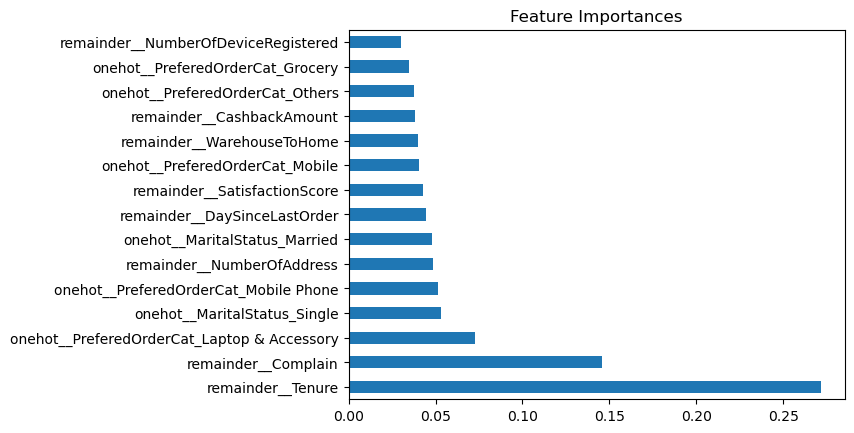

In [42]:
coef1 = pd.Series(best_model2['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Tenure is the most important feature for this XGB Model, followed by Complain, PreferedOrderCat of Laptop & Accessory, etc.

We can infer that while Tenure is the most important feature followed by Complain, their Prefered Order Category is also very important in predicting judging from their overall rankings. Other than that, the data is missing Demographic information of the customers other than marital status to infer more regarding the importance of their demographic profile.



## Conclusion:


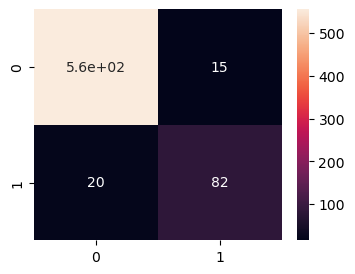

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       571
           1       0.85      0.80      0.82       102

    accuracy                           0.95       673
   macro avg       0.91      0.89      0.90       673
weighted avg       0.95      0.95      0.95       673



In [39]:
plt.figure(figsize = (4,3))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned2), annot=True)
plt.show()
print('Classification Report: \n', report_tuned2)


**Performance**

Based on the classification Report, we can conclude that this model has the capability to identify 80% of the customers who are at risk of churning (based on Recall(P) value), and so the company can try to implement a retention effort to those customers to prevent them from churning.

The model also have 85% accuracy (based on Precision(P) value) on their prediction, meaning when the model predicts that a customer is at risk of churning, there is 85% chance of the prediction being true.

Considering the goal for this model is to identifying customers who are at risk of churning as well as making sure that only customers at risk of churning receive the retention, this model strikes the balance between both goals quite well with the f1-score of 0.82

**Profit Opportunity:**

If used, this model can help the company to discriminate customers who would not churn from those who are at risk of churning with the accuracy of 85% (Precision). As such, 

Let's say the respective e-commerce company would like to distribute a $2 coupon to customers to prevent churning, and they have 50 million active buyers (1/3 of AliExpress, based on source of https://www.chinainternetwatch.com/tag/aliexpress/#:~:text=AliExpress%20platform%20is%20localized%20for,with%20over%20200%20million%20visits.), with only 7.5 million customers (15%, just like the proportion in this data) at risk of churing.

If we translate the scenario into our model performance:
- `True Positive` (Predicted to Churn Correctly): 7.5M x 0.8 = `6M people` (Recall(P) is 80%)
- `False Negative` (Predicted to Not Churn Incorrectly; will actually churn): 7.5M - 6M = `1.5M` `people`
- `True Negative` (Predicted to Not Churn Correctly): 42.5M x 0.97 = `41.225M people` (Recall(N) is 97%)
- `False Positive` (Predicted to Churn Incorrectly; no risk of churn): 42.5M - 41.225M = `1.275M` `people`

Without using the model (company distribute to all customers):
- `Total cost` => 2 x 50xM USD =  `100M USD`
- Total customers avoided churning => 7.5M people (because we distribute to all)
- `Wasted costs` => 42.5M x 2 USD = `85M USD` (because 42.5M would not churn in the first place)


Using the model (company check and offer only customers who are predicted as at risk of churning):
- `Total cost` => 2 x (TP + FP) USD = 2 x (6M + 1.275M) USD =  `14.55M USD`
- Total customers avoided churning => 6M (Recall(P) is 80%)
- `Wasted costs` => 2 x FP USD = `2.55 USD`

`Amount of savings from using the model` => 85M - 2.55 = `82.45 USD`


**Model Limitation:**

The Model is only capable of identifying 80% of Customers at risk of Churning, as such the company will still have to risk losing 20% of the Churn-Risk Customers. The model also only have the accuracy of 85% when predicting customers to be at risk of churning, and may lead to some loss due to improper retention effort distribution. As such, certainly there is always a room for improvement

Other than that, due to model being based on Decision Tree XGBoost, there is low interpretability to understand the criterias that is used to infer why a customer would churn aside from the importance of certain feature.

For example, while we do know Tenure is the most important feature by a huge margin, it is hard for us to interpret if having larger Tenure would lead to decrease of Churn Risk and vice versa.


### Recommendations:

Things that can be done to develop the project and the model better:
- Ensure that the data collection is complete to reduce Missing Values, especially in `Tenure`, `WarehouseToHome`, and `DaySinceLastOrder`, which supposed to be easy to track by considering account history & shipment address
- Add more features that could describe the customer's demographic better, such as Gender, Education Level, Age, and maybe even Income if possible. This will help tremendously on profiling them demographically and makes the model less dependent towards their account history and purchase behaviour.
- Trying other Data Balancing Techniques, ML algorithms and Hyperparameter Tuning may help increase the performance of future models.
- Conduction Exploratory Data Analysis would help to find the trends regarding the characteristics of customers who would churn, and with that we can link them with the Feature Importance outcome from the model to truly understand the direction of the importance (example: higher tenure = less risk of churn), etc.
- Additional data analysis on data incorrectly predicted by the model can help find their characteristics to potentially increase accuracy (precision) in future models.